In [1]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.6/install/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import sys
import warnings

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample
    
def load_data(path='datasets/fer2013/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping


def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
        ])
    else:
        train_transform = test_transform

    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

In [4]:
import os
def save(net, logger, hps, epoch):
    # Create the path the checkpint will be saved at using the epoch number
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(epoch))

    # create a dictionary containing the logger info and model info that will be saved
    checkpoint = {
        'logs': logger.get_logs(),
        'params': net.state_dict()
    }

    # save checkpoint
    torch.save(checkpoint, path)


def restore(net, logger, hps):
    """ Load back the model and logger from a given checkpoint
        epoch detailed in hps['restore_epoch'], if available"""
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(hps['restore_epoch']))

    if os.path.exists(path):
        try:
            checkpoint = torch.load(path)

            logger.restore_logs(checkpoint['logs'])
            net.load_state_dict(checkpoint['params'])
            print("Network Restored!")

        except Exception as e:
            print("Restore Failed! Training from scratch.")
            print(e)
            hps['start_epoch'] = 0

    else:
        print("Restore point unavailable. Training from scratch.")
        hps['start_epoch'] = 0


def load_features(model, params):
    """ Load params into all layers of 'model'
        that are compatible, then freeze them"""
    model_dict = model.state_dict()

    imp_params = {k: v for k, v in params.items() if k in model_dict}

    # Load layers
    model_dict.update(imp_params)
    model.load_state_dict(imp_params)

    # Freeze layers
    for name, param in model.named_parameters():
        param.requires_grad = False

In [5]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 300,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': None,  # continue training from a specific saved point
    'start_epoch': 0,
    'lr': 0.01,  # starting learning rate
    'save_freq': 20,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'vggcheckpoints', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])

In [6]:
from torch.cuda.amp import autocast

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(net, dataloader, criterion, optimizer, scaler, Ncrop=True):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    iters = len(dataloader)  # number of batches, not images

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            if Ncrop:
                # fuse crops and batchsize
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)

            # repeat labels ncrops times
            labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # scheduler.step(epoch + i / iters)

            # calculate performance metrics
            loss_tr += loss.item()

            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss


def evaluate(net, dataloader, criterion, Ncrop=True):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        if Ncrop:
            # fuse crops and batchsize
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)
            # forward
            outputs = net(inputs)
            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
        else:
            outputs = net(inputs)

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [7]:
from matplotlib import pyplot as plt

class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def save_plt(self, hps):
        loss_path = os.path.join(hps['model_save_dir'], 'loss.jpg')
        acc_path = os.path.join(hps['model_save_dir'], 'acc.jpg')

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.savefig(acc_path)

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(loss_path)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

In [9]:
import timm

class EfficientNet(nn.Module):
    def __init__(self, pretrained=True, drop=0.1):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 7)

    def forward(self, x):
        # print(x.shape)
        x = x.repeat(1, 3, 1, 1)
        # print(x.shape)
        
        x = self.model(x)
        return x


MESSAGE FROM RCS: Setting LC_ALL and LANG to locale value 'en_US.utf8'.  If you wish to use a different locale, use the following code to set it to your prefered locale prior to importing click.
###############################
import os
os.environ["LC_ALL"]="new locale"
os.environ["LANG"]=os.environ["LC_ALL"]
###############################



In [10]:
#from models import vgg, efn
#nets = {
#    'vgg': vgg.Vgg,
#    'efn': efn.EfficientNet
#}


def setup_network(hps):
    #net = nets[hps['network']]()
    net = Vgg()

    # Prepare logger
    logger = Logger()
    if hps['restore_epoch']:
        restore(net, logger, hps)

    return logger, net

In [11]:
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = float(hps['lr'])
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [12]:
logger, net = setup_network(hps)
net

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Training myvgg on cuda:0
Epoch  1		Train Accuracy: 33.2331 %		Val Accuracy: 46.0574 %
Epoch  2		Train Accuracy: 47.5259 %		Val Accuracy: 51.7693 %
Epoch  3		Train Accuracy: 52.2937 %		Val Accuracy: 57.0911 %
Epoch  4		Train Accuracy: 54.8278 %		Val Accuracy: 61.2705 %
Epoch  5		Train Accuracy: 57.0204 %		Val Accuracy: 60.3511 %
Epoch  6		Train Accuracy: 58.0849 %		Val Accuracy: 63.2210 %
Epoch  7		Train Accuracy: 59.3859 %		Val Accuracy: 63.7782 %
Epoch  8		Train Accuracy: 60.4511 %		Val Accuracy: 63.6668 %
Epoch  9		Train Accuracy: 61.2564 %		Val Accuracy: 63.6668 %
Epoch 10		Train Accuracy: 62.1502 %		Val Accuracy: 65.7008 %
Epoch 11		Train Accuracy: 63.0043 %		Val Accuracy: 64.9763 %
Epoch 12		Train Accuracy: 63.8211 %		Val Accuracy: 66.1466 %
Epoch 13		Train Accuracy: 64.3526 %		Val Accuracy: 65.1714 %
Epoch 14		Train Accuracy: 64.9417 %		Val Accuracy: 65.8679 %
Epoch 15		Train Accuracy: 65.6383 %		Val Accuracy: 66.4531 %
Epoch 16		Train Accuracy: 66.3841 %		Val Accuracy: 66.9824 %

Epoch 126		Train Accuracy: 94.7853 %		Val Accuracy: 73.7531 %
Epoch 127		Train Accuracy: 94.7856 %		Val Accuracy: 73.7531 %
Epoch   128: reducing learning rate of group 0 to 5.6314e-04.
Epoch 128		Train Accuracy: 94.7633 %		Val Accuracy: 73.6138 %
Epoch 129		Train Accuracy: 94.8180 %		Val Accuracy: 74.1989 %
Epoch 130		Train Accuracy: 94.8814 %		Val Accuracy: 73.6974 %
Epoch 131		Train Accuracy: 94.8967 %		Val Accuracy: 73.7253 %
Epoch 132		Train Accuracy: 94.9382 %		Val Accuracy: 73.5302 %
Epoch 133		Train Accuracy: 94.9242 %		Val Accuracy: 73.7531 %
Epoch   134: reducing learning rate of group 0 to 4.2235e-04.
Epoch 134		Train Accuracy: 94.8142 %		Val Accuracy: 73.6974 %
Epoch 135		Train Accuracy: 94.9256 %		Val Accuracy: 73.3352 %
Epoch 136		Train Accuracy: 94.9497 %		Val Accuracy: 73.3909 %
Epoch 137		Train Accuracy: 94.9988 %		Val Accuracy: 73.8089 %
Epoch 138		Train Accuracy: 95.0413 %		Val Accuracy: 73.8646 %
Epoch 139		Train Accuracy: 94.9915 %		Val Accuracy: 74.0039 %
Epoch   

Epoch 240		Train Accuracy: 95.2349 %		Val Accuracy: 73.6417 %
Epoch 241		Train Accuracy: 95.4384 %		Val Accuracy: 73.7810 %
Epoch   242: reducing learning rate of group 0 to 2.3811e-06.
Epoch 242		Train Accuracy: 95.3325 %		Val Accuracy: 73.8089 %
Epoch 243		Train Accuracy: 95.2865 %		Val Accuracy: 73.8646 %
Epoch 244		Train Accuracy: 95.3596 %		Val Accuracy: 73.7253 %
Epoch 245		Train Accuracy: 95.2287 %		Val Accuracy: 73.8089 %
Epoch 246		Train Accuracy: 95.3408 %		Val Accuracy: 73.8924 %
Epoch 247		Train Accuracy: 95.3043 %		Val Accuracy: 73.8646 %
Epoch   248: reducing learning rate of group 0 to 1.7858e-06.
Epoch 248		Train Accuracy: 95.3245 %		Val Accuracy: 73.8924 %
Epoch 249		Train Accuracy: 95.2736 %		Val Accuracy: 73.6974 %
Epoch 250		Train Accuracy: 95.3631 %		Val Accuracy: 73.7531 %
Epoch 251		Train Accuracy: 95.3213 %		Val Accuracy: 73.8646 %
Epoch 252		Train Accuracy: 95.4213 %		Val Accuracy: 73.6417 %
Epoch 253		Train Accuracy: 95.2774 %		Val Accuracy: 73.7531 %
Epoch   

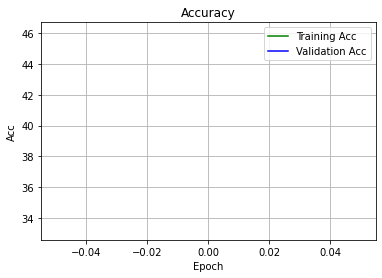

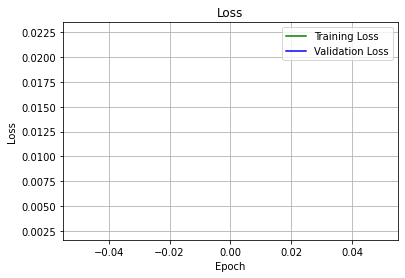

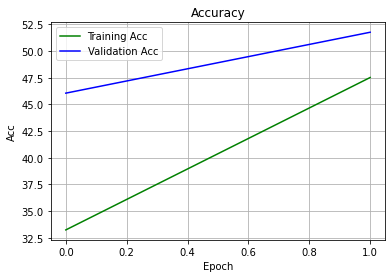

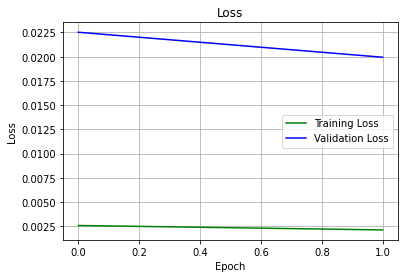

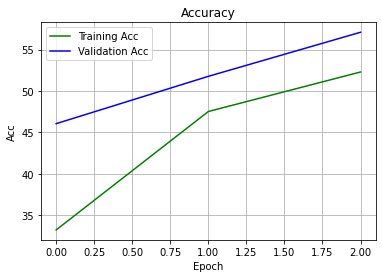

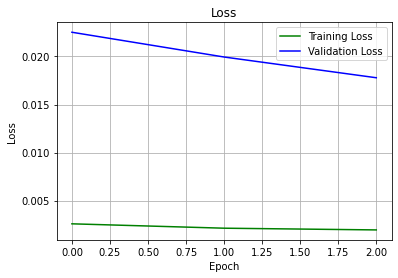

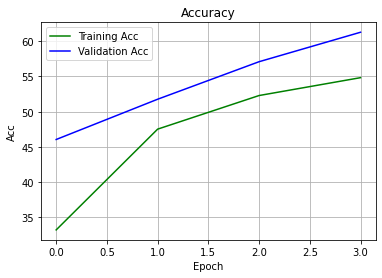

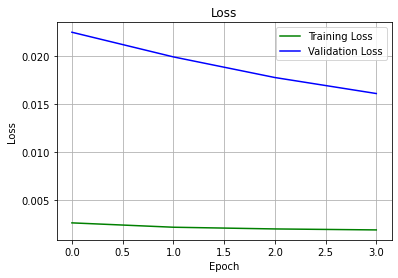

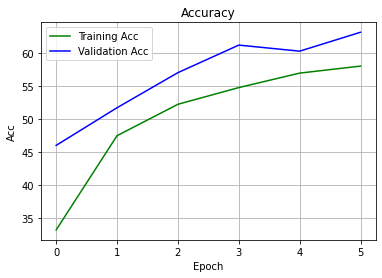

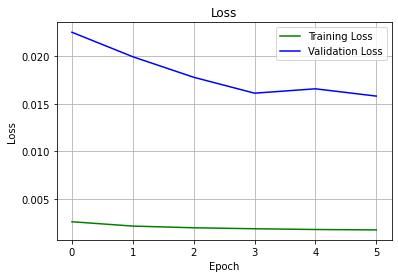

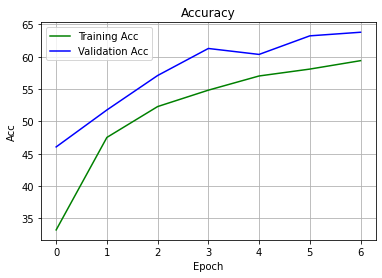

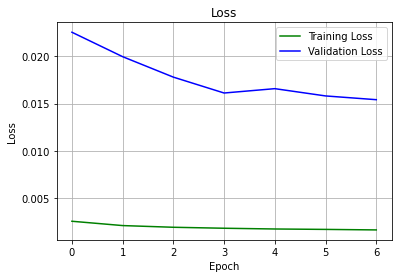

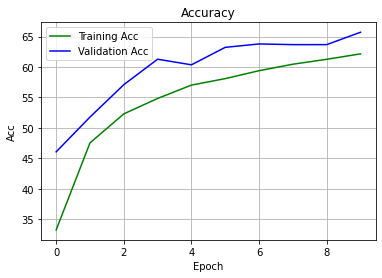

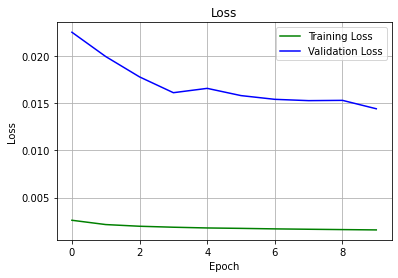

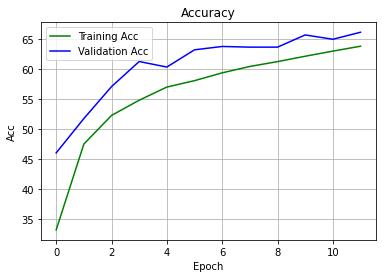

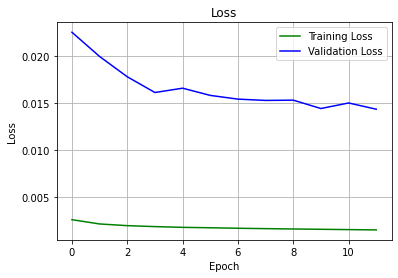

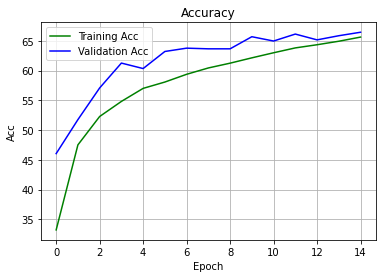

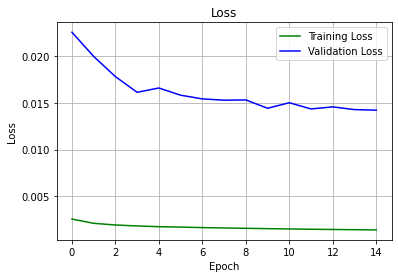

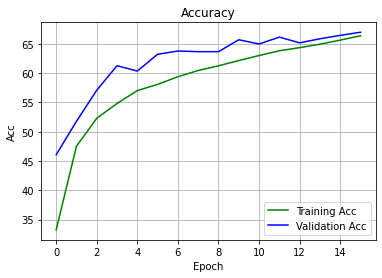

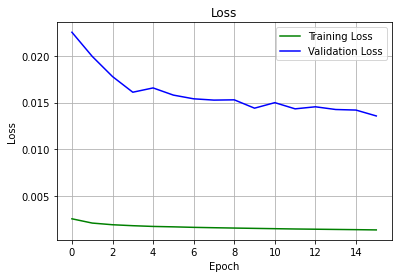

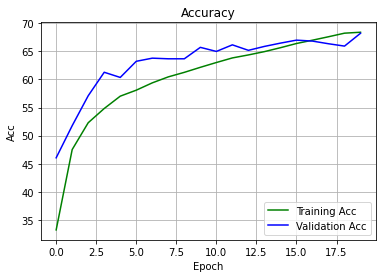

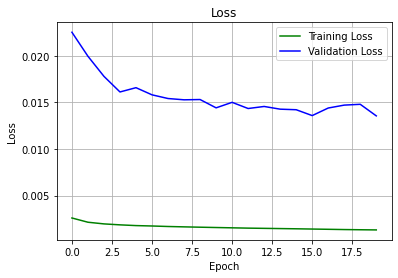

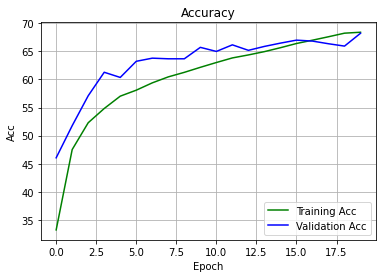

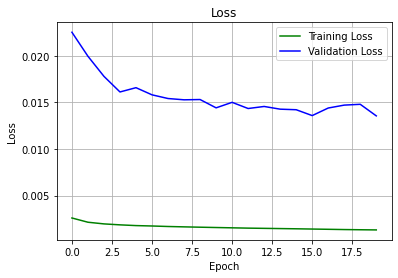

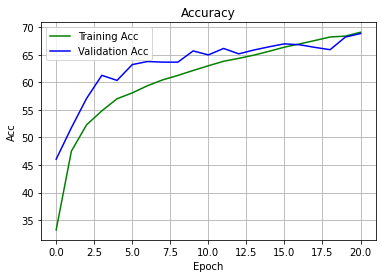

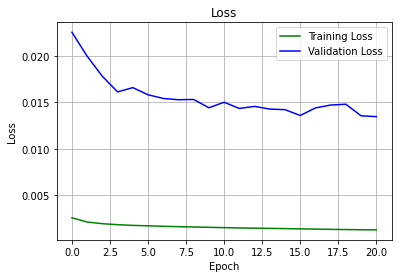

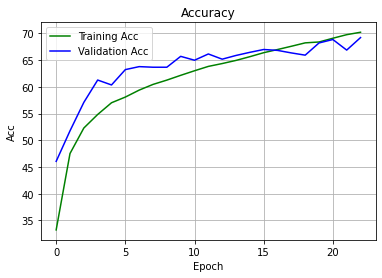

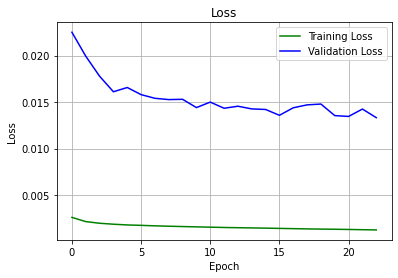

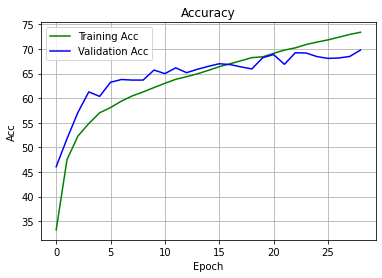

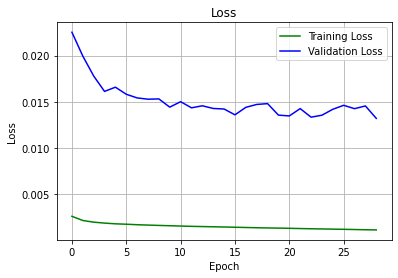

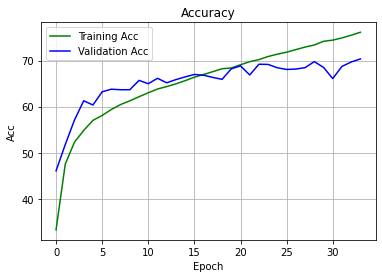

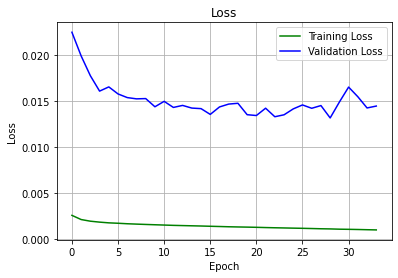

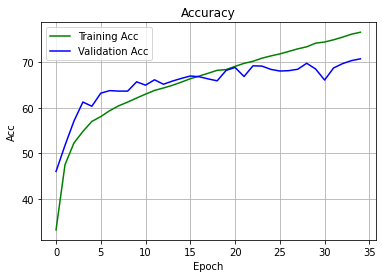

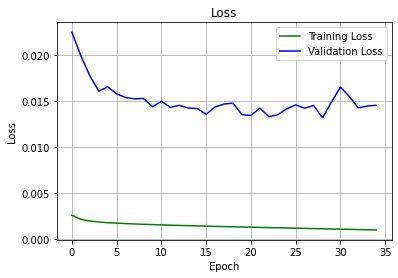

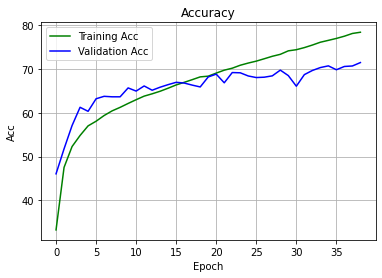

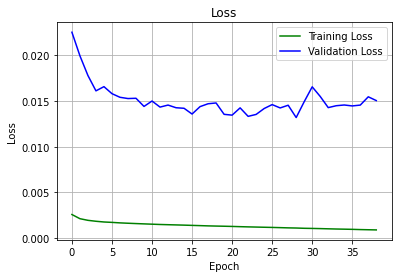

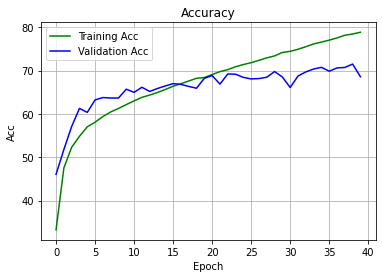

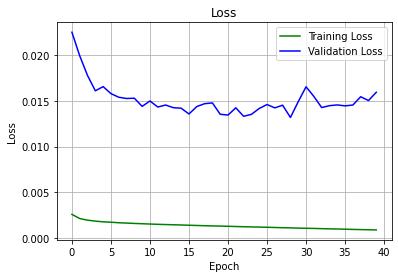

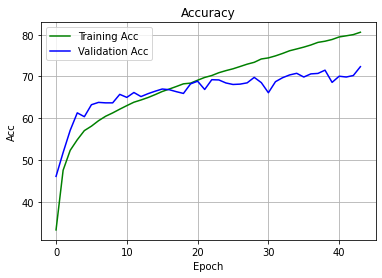

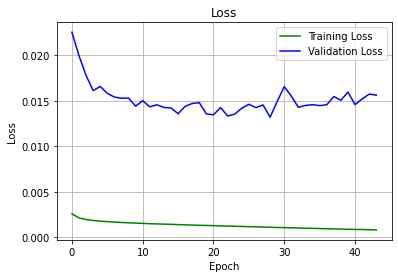

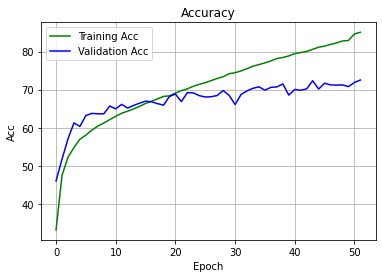

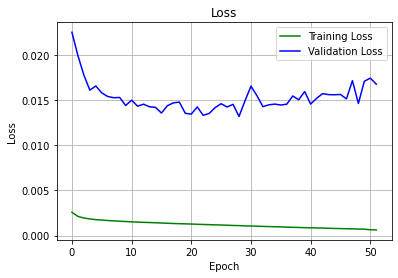

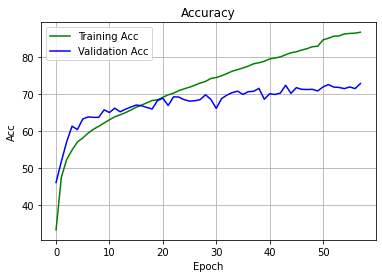

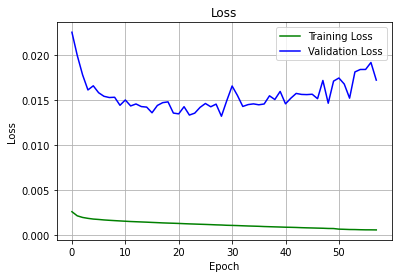

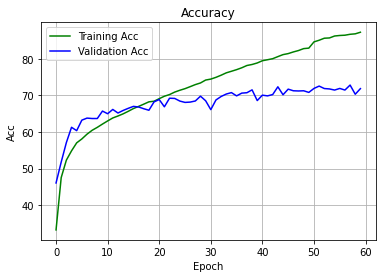

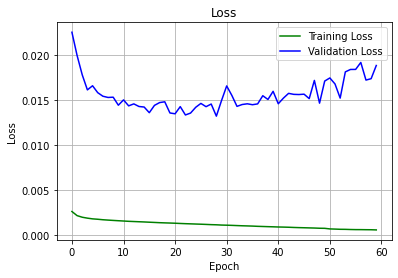

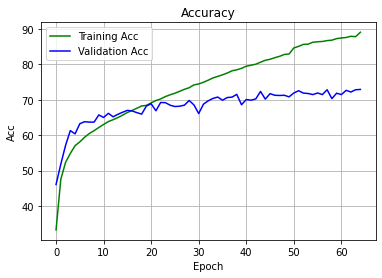

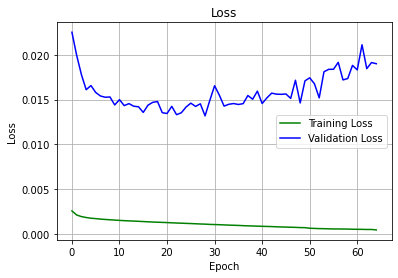

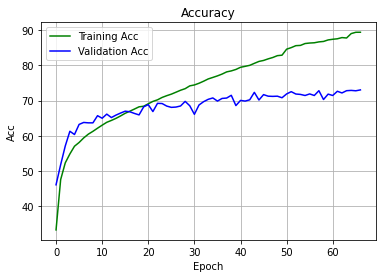

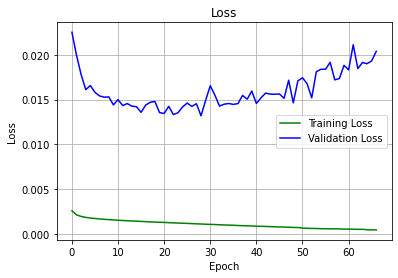

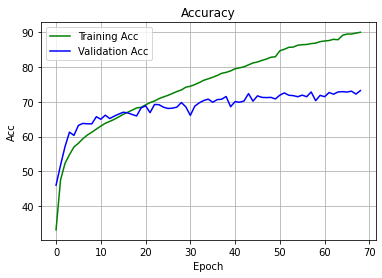

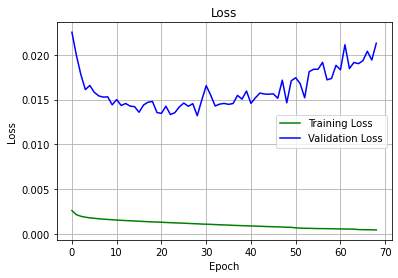

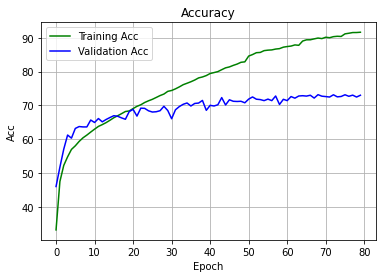

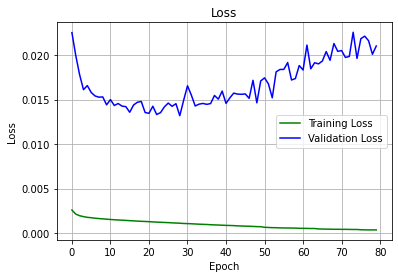

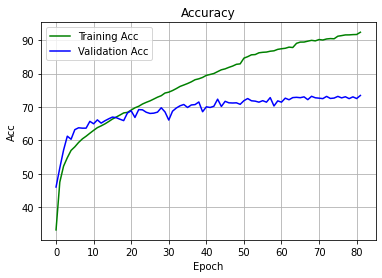

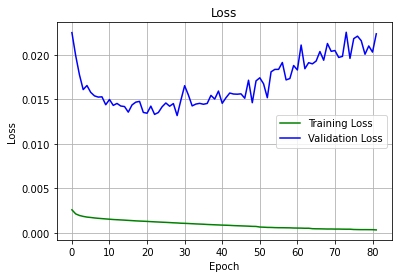

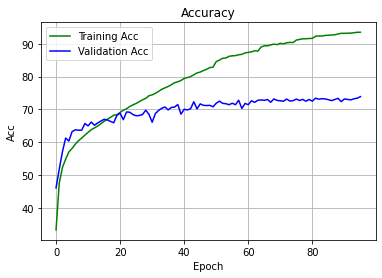

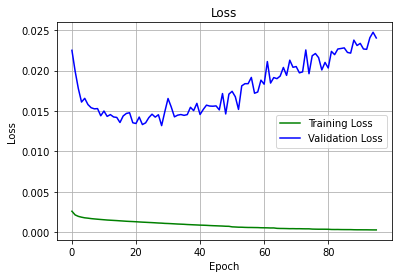

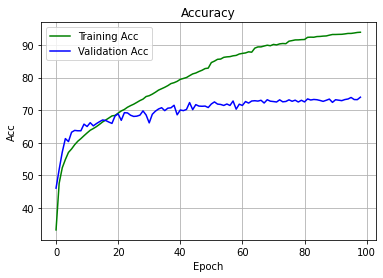

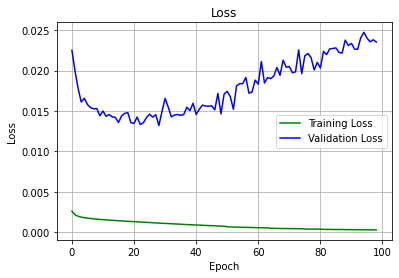

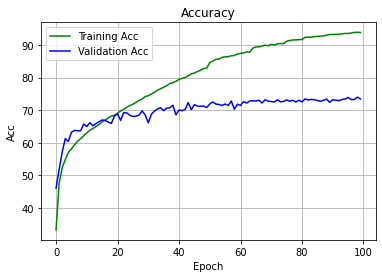

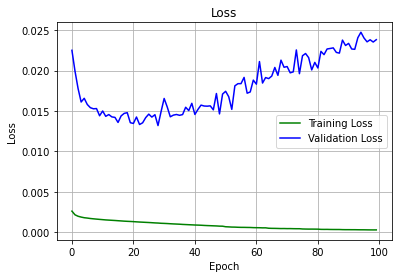

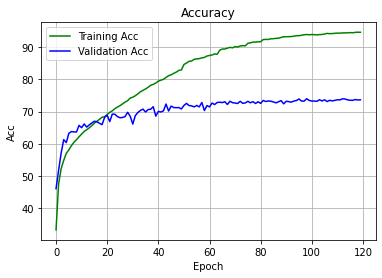

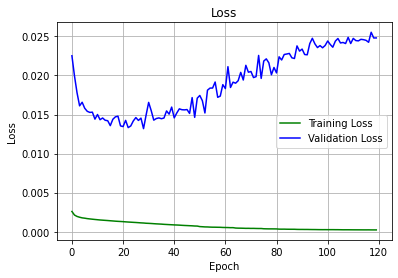

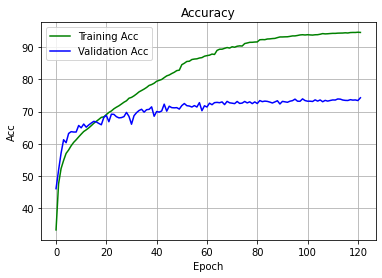

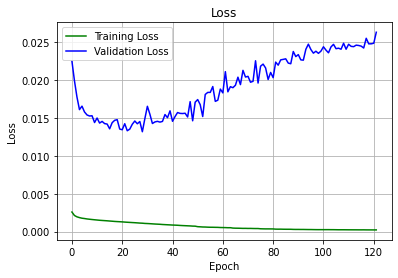

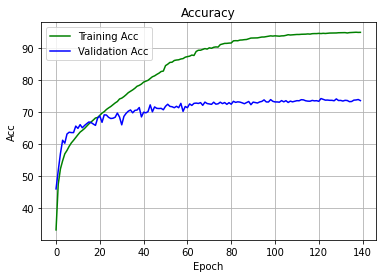

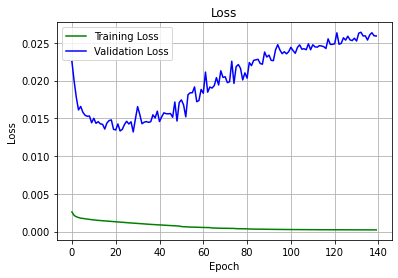

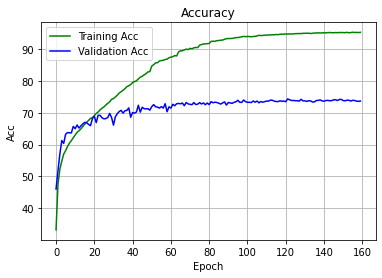

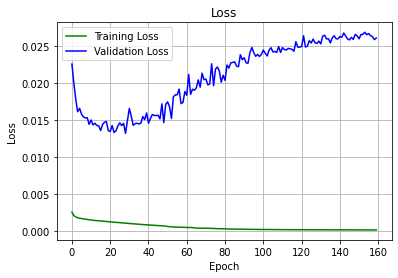

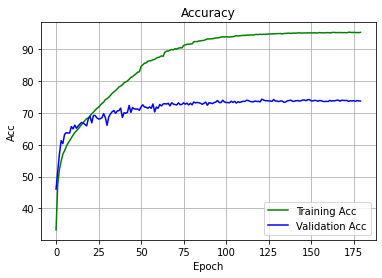

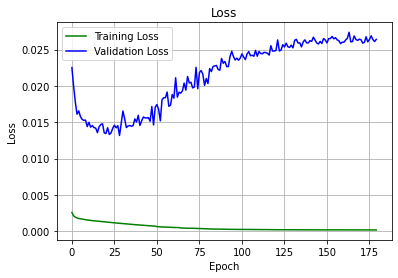

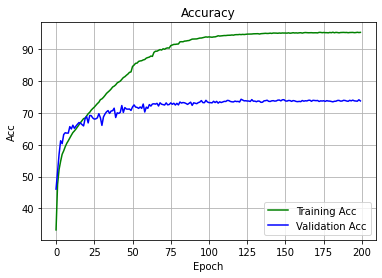

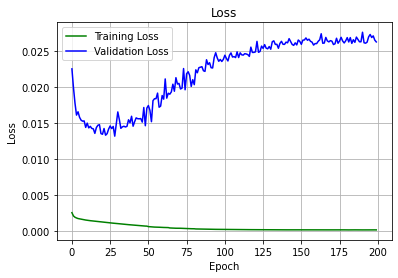

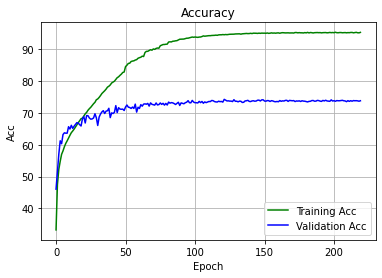

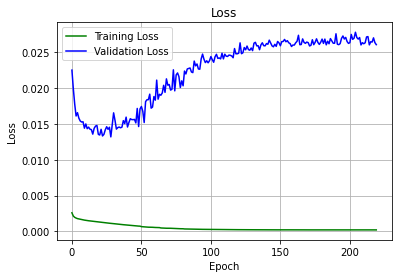

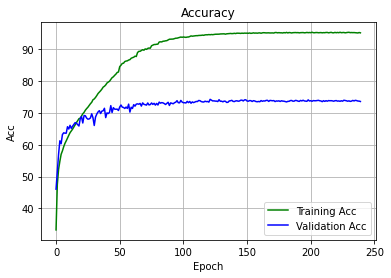

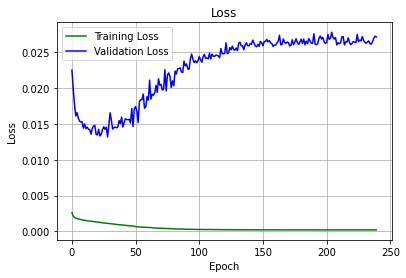

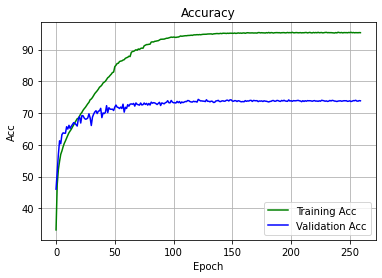

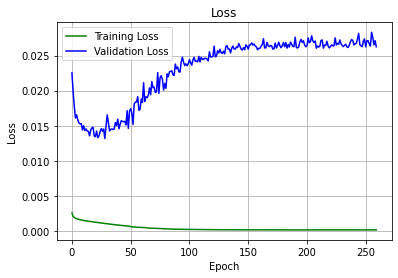

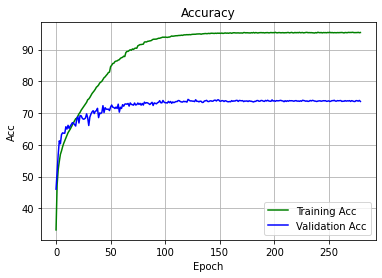

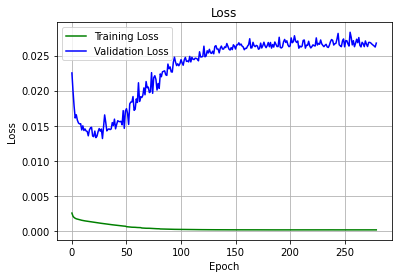

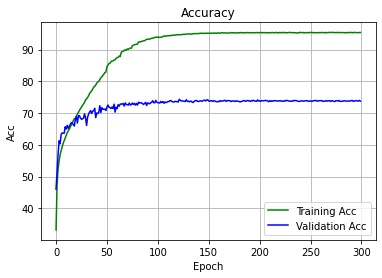

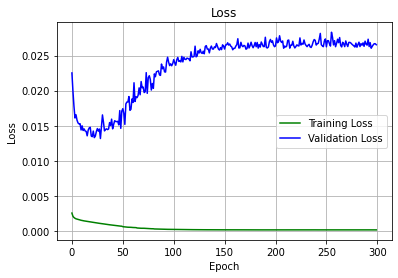

In [13]:
run(net, logger, hps)

In [12]:
def setup_network(hps):
    #net = nets[hps['network']]()
    net = EfficientNet()

    # Prepare logger
    logger = Logger()
    if hps['restore_epoch']:
        restore(net, logger, hps)

    return logger, net
hps = {
    'network': 'efn',  # which network do you want to train
    'name': 'myefn',  # whatever you want to name your run
    'n_epochs': 300,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': None,  # continue training from a specific saved point
    'start_epoch': 0,
    'lr': 0.01,  # starting learning rate
    'save_freq': 20,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'efncheckpoints', hps['name'])
if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])
logger, efn = setup_network(hps)
efn

EfficientNet(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (

Training myefn on cuda:0
Epoch  1		Train Accuracy: 33.3728 %		Val Accuracy: 49.0109 %
Epoch  2		Train Accuracy: 43.4383 %		Val Accuracy: 55.8373 %
Epoch  3		Train Accuracy: 48.3235 %		Val Accuracy: 59.0694 %
Epoch  4		Train Accuracy: 50.8001 %		Val Accuracy: 59.9331 %
Epoch  5		Train Accuracy: 53.0088 %		Val Accuracy: 61.2427 %
Epoch  6		Train Accuracy: 54.4777 %		Val Accuracy: 62.4408 %
Epoch  7		Train Accuracy: 55.9107 %		Val Accuracy: 63.4717 %
Epoch  8		Train Accuracy: 56.8947 %		Val Accuracy: 64.4748 %
Epoch  9		Train Accuracy: 57.7418 %		Val Accuracy: 64.8649 %
Epoch 10		Train Accuracy: 58.9582 %		Val Accuracy: 65.6729 %
Epoch 11		Train Accuracy: 59.7112 %		Val Accuracy: 65.4778 %
Epoch 12		Train Accuracy: 60.4786 %		Val Accuracy: 67.0660 %
Epoch 13		Train Accuracy: 61.3149 %		Val Accuracy: 65.8679 %
Epoch 14		Train Accuracy: 61.8245 %		Val Accuracy: 67.2889 %
Epoch 15		Train Accuracy: 62.8319 %		Val Accuracy: 67.4840 %
Epoch 16		Train Accuracy: 63.5174 %		Val Accuracy: 68.2920 %

Epoch 123		Train Accuracy: 92.5292 %		Val Accuracy: 70.5210 %
Epoch 124		Train Accuracy: 92.4205 %		Val Accuracy: 70.4374 %
Epoch   125: reducing learning rate of group 0 to 2.3757e-04.
Epoch 125		Train Accuracy: 92.4947 %		Val Accuracy: 70.4653 %
Epoch 126		Train Accuracy: 92.5093 %		Val Accuracy: 70.4374 %
Epoch 127		Train Accuracy: 92.6253 %		Val Accuracy: 70.5489 %
Epoch 128		Train Accuracy: 92.5633 %		Val Accuracy: 70.4932 %
Epoch 129		Train Accuracy: 92.5933 %		Val Accuracy: 70.6882 %
Epoch 130		Train Accuracy: 92.6163 %		Val Accuracy: 70.3539 %
Epoch   131: reducing learning rate of group 0 to 1.7818e-04.
Epoch 131		Train Accuracy: 92.6055 %		Val Accuracy: 70.4374 %
Epoch 132		Train Accuracy: 92.7235 %		Val Accuracy: 70.2703 %
Epoch 133		Train Accuracy: 92.4926 %		Val Accuracy: 70.4096 %
Epoch 134		Train Accuracy: 92.6814 %		Val Accuracy: 70.1867 %
Epoch 135		Train Accuracy: 92.7284 %		Val Accuracy: 70.2145 %
Epoch 136		Train Accuracy: 92.6295 %		Val Accuracy: 70.4374 %
Epoch   

Epoch 237		Train Accuracy: 92.8489 %		Val Accuracy: 70.3817 %
Epoch 238		Train Accuracy: 92.9033 %		Val Accuracy: 70.2145 %
Epoch   239: reducing learning rate of group 0 to 1.0045e-06.
Epoch 239		Train Accuracy: 92.8594 %		Val Accuracy: 70.3260 %
Epoch 240		Train Accuracy: 92.8883 %		Val Accuracy: 70.2424 %
Epoch 241		Train Accuracy: 92.8914 %		Val Accuracy: 70.3817 %
Epoch 242		Train Accuracy: 92.7664 %		Val Accuracy: 70.4653 %
Epoch 243		Train Accuracy: 92.7890 %		Val Accuracy: 70.4932 %
Epoch 244		Train Accuracy: 92.8148 %		Val Accuracy: 70.3260 %
Epoch   245: reducing learning rate of group 0 to 7.5339e-07.
Epoch 245		Train Accuracy: 92.8378 %		Val Accuracy: 70.7997 %
Epoch 246		Train Accuracy: 92.7281 %		Val Accuracy: 70.4096 %
Epoch 247		Train Accuracy: 92.7862 %		Val Accuracy: 70.2703 %
Epoch 248		Train Accuracy: 92.8583 %		Val Accuracy: 70.2981 %
Epoch 249		Train Accuracy: 92.7619 %		Val Accuracy: 70.2981 %
Epoch 250		Train Accuracy: 92.9614 %		Val Accuracy: 70.1867 %
Epoch   

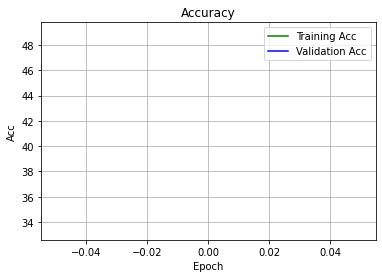

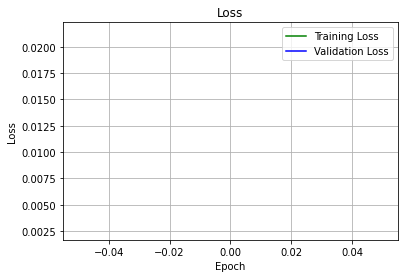

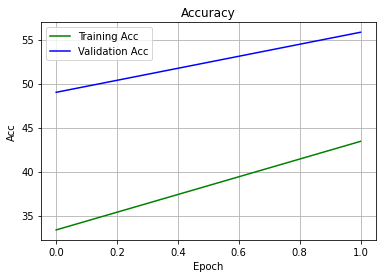

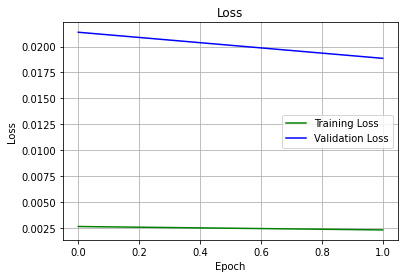

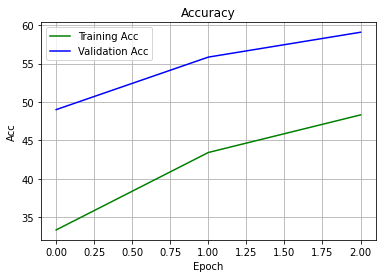

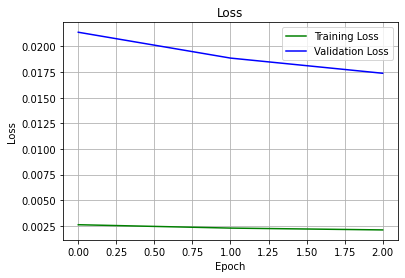

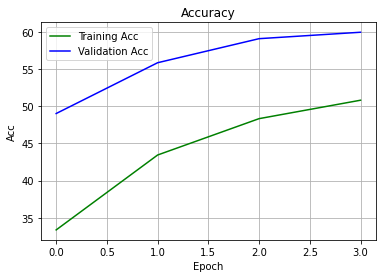

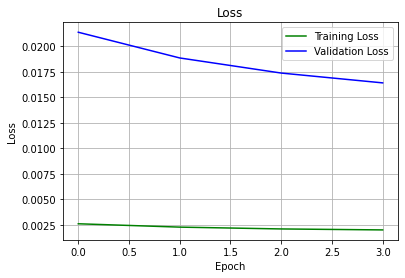

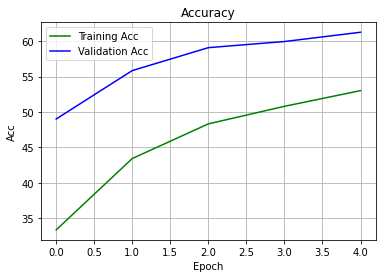

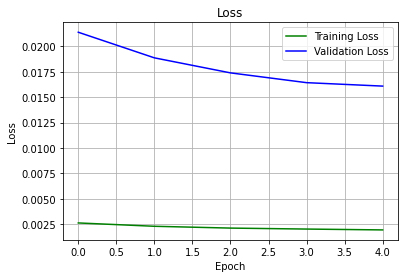

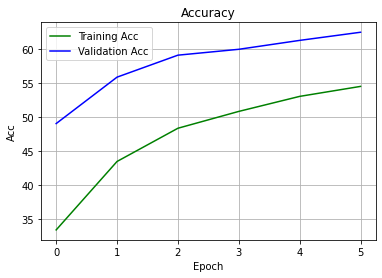

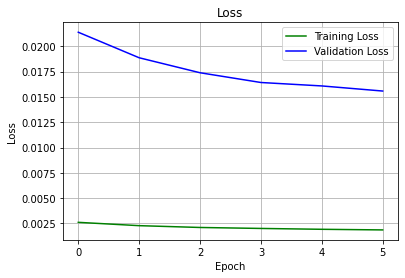

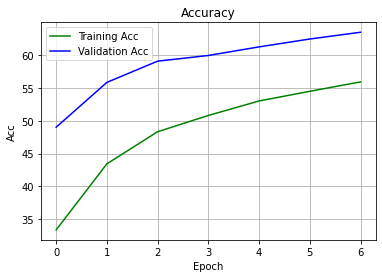

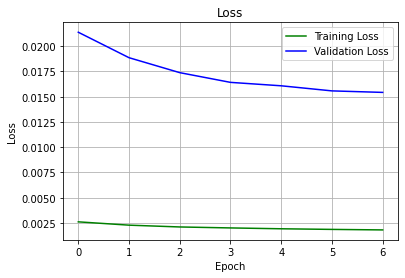

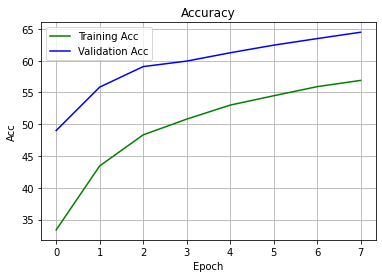

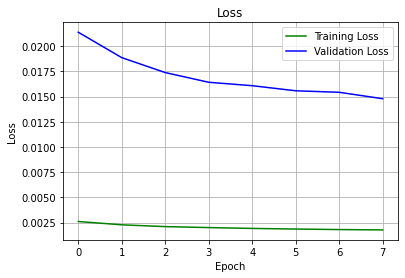

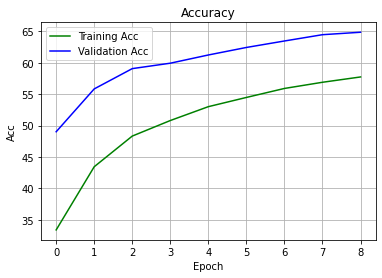

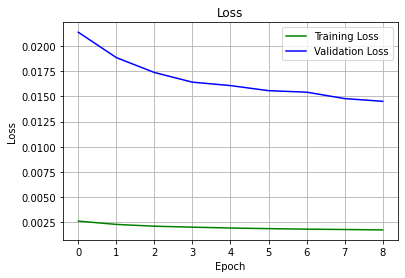

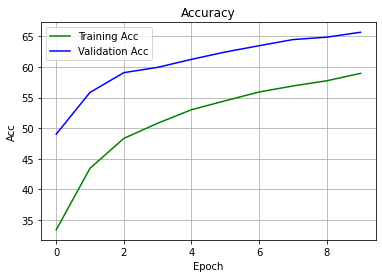

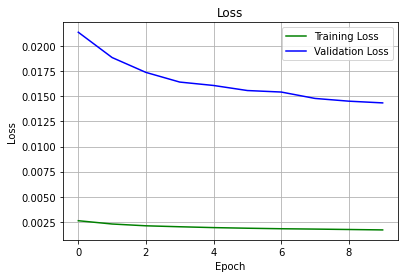

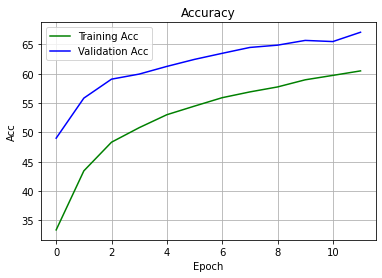

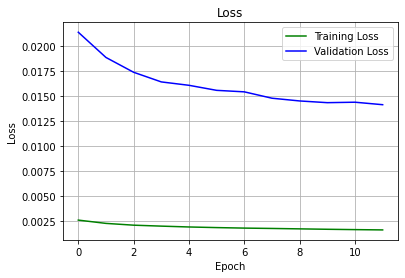

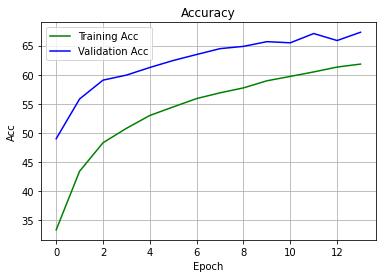

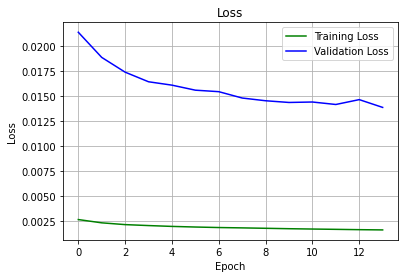

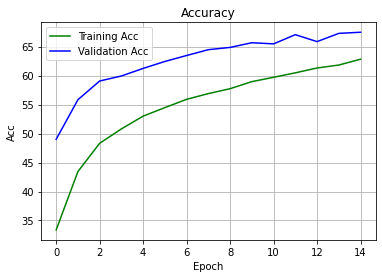

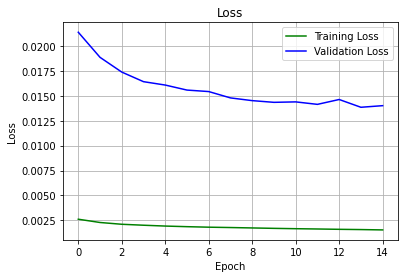

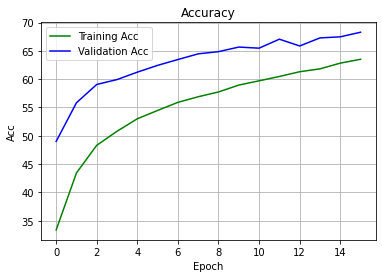

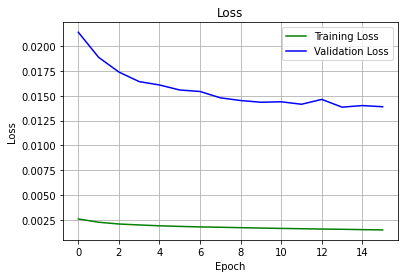

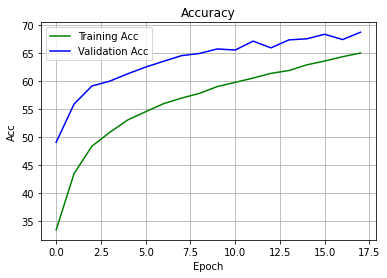

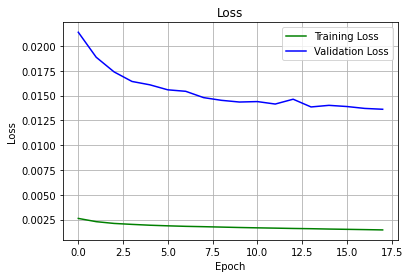

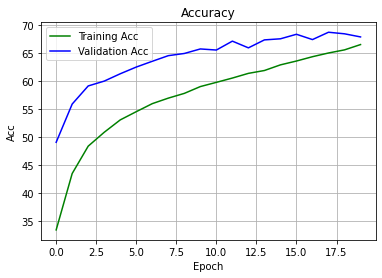

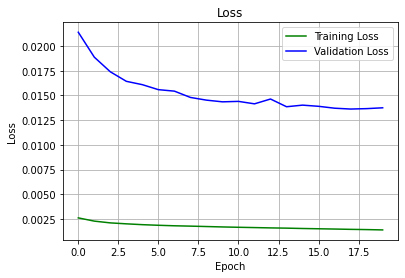

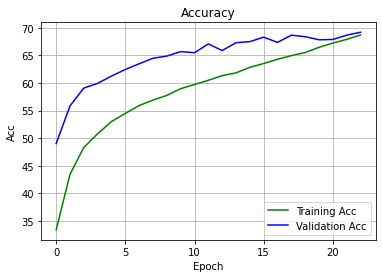

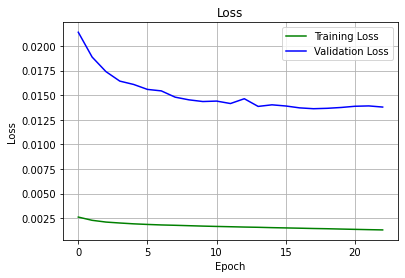

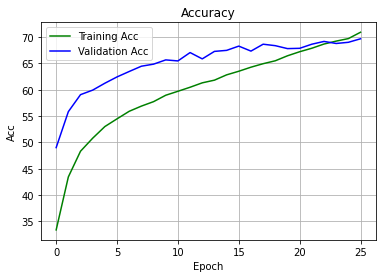

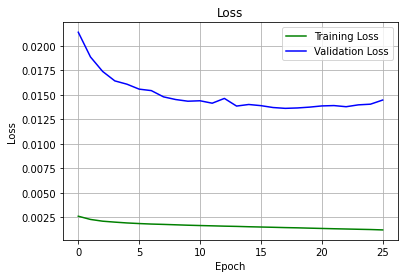

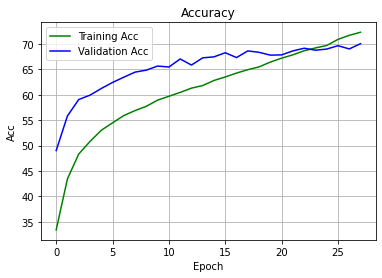

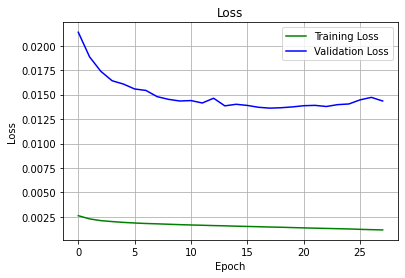

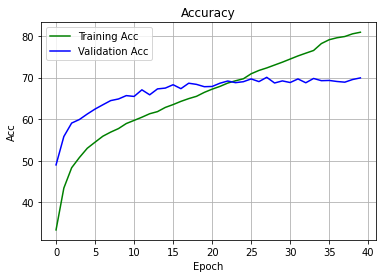

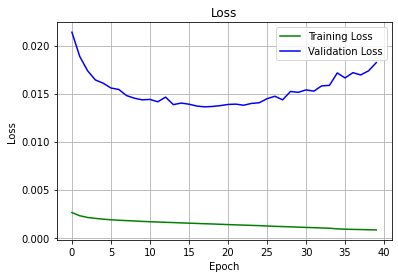

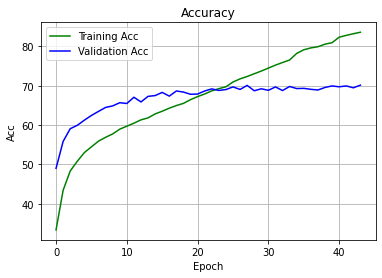

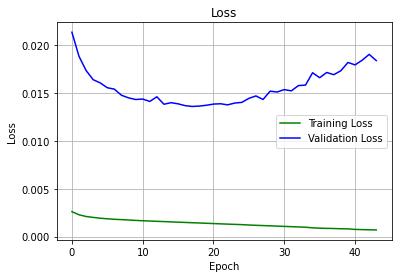

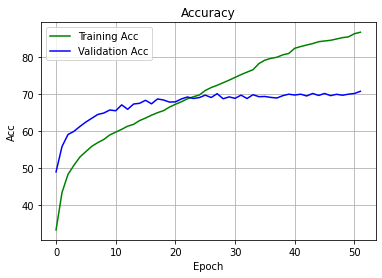

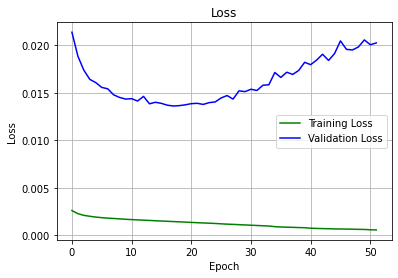

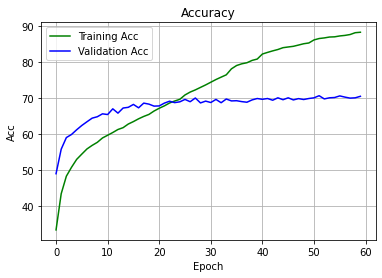

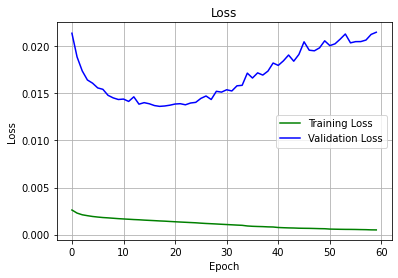

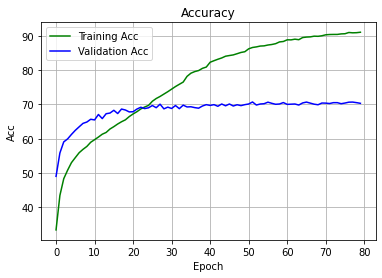

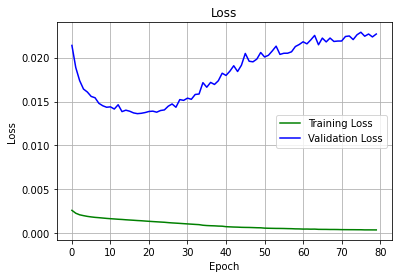

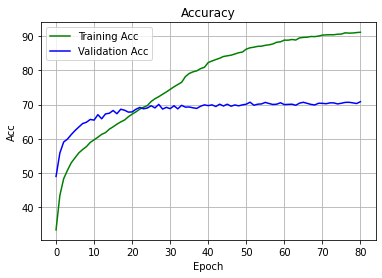

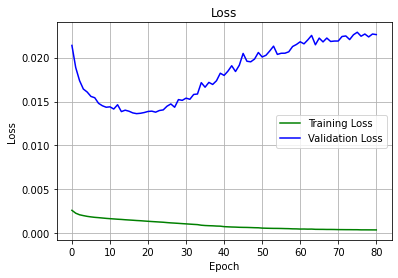

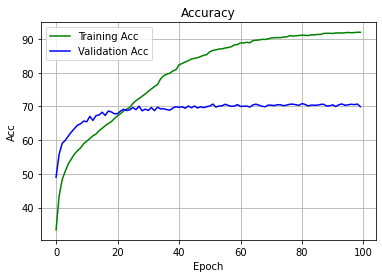

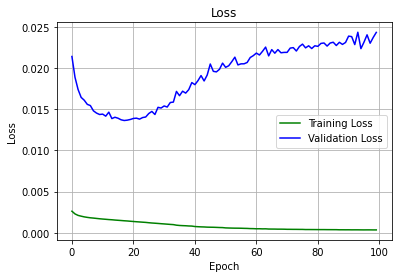

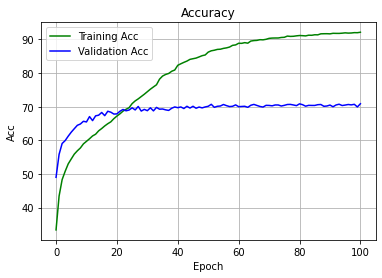

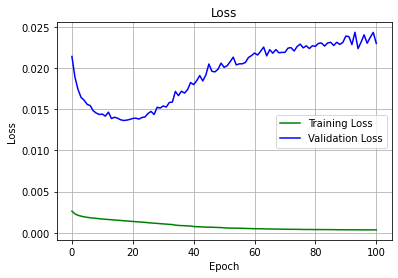

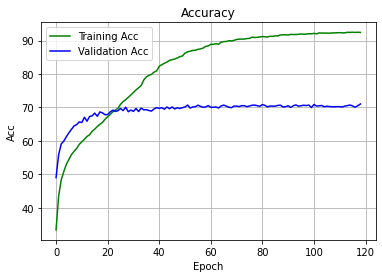

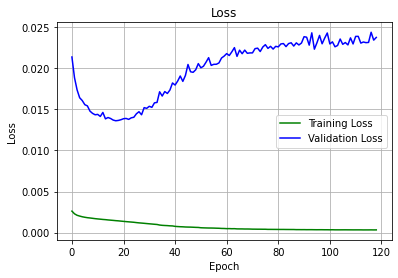

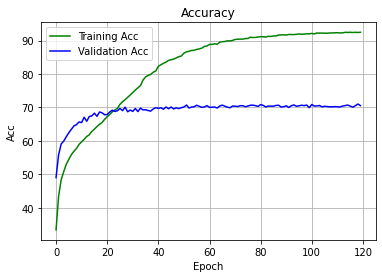

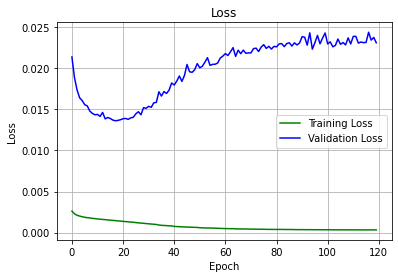

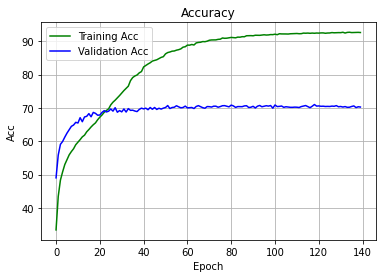

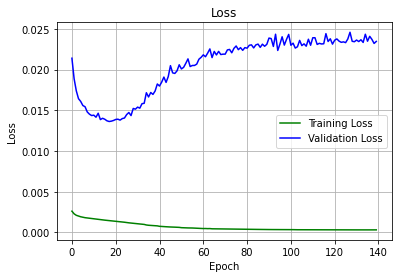

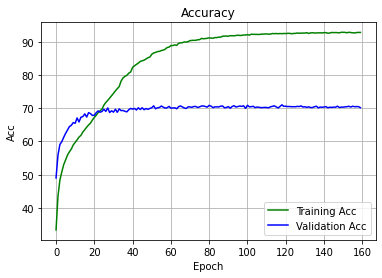

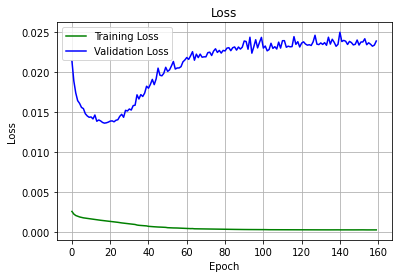

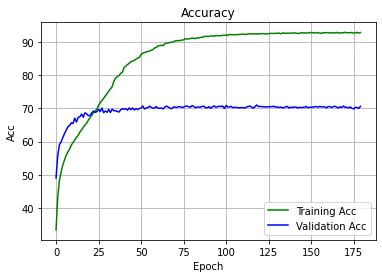

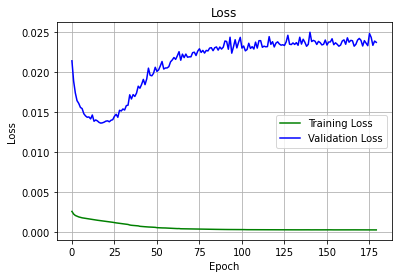

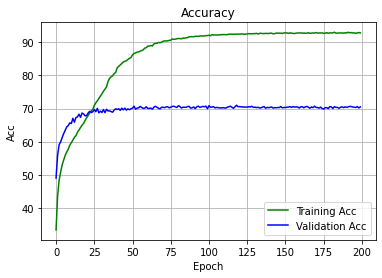

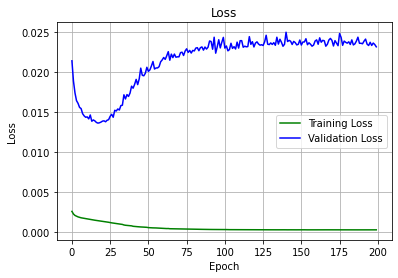

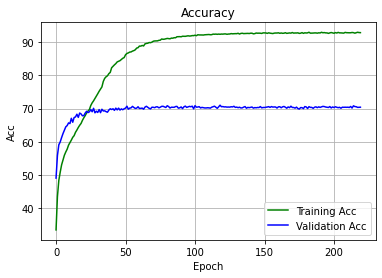

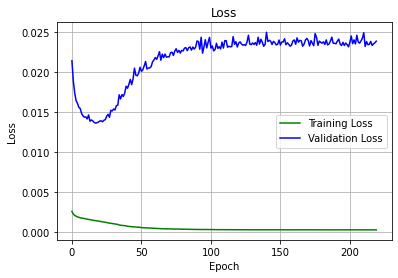

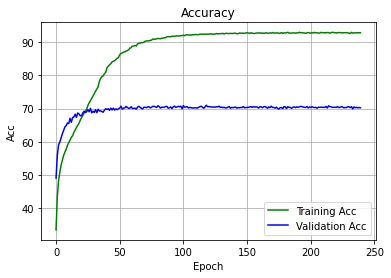

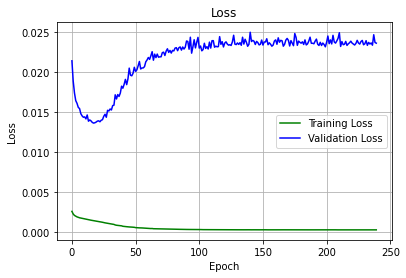

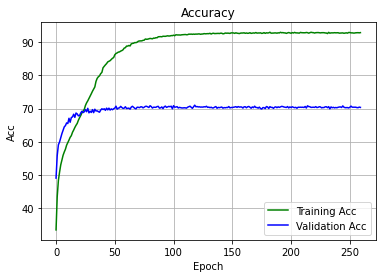

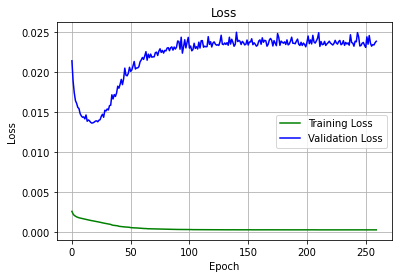

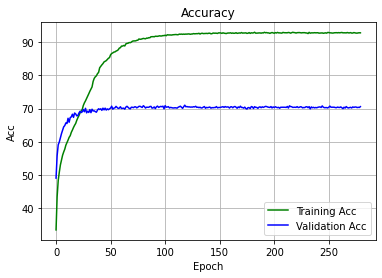

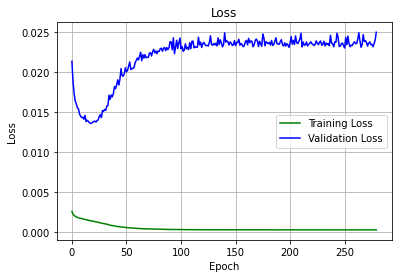

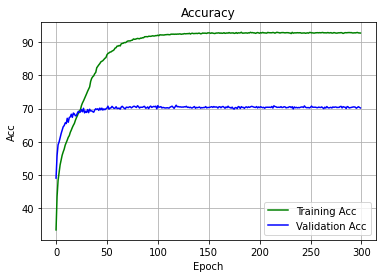

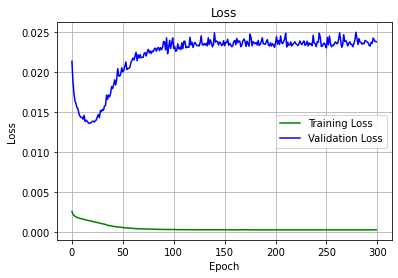

In [13]:
run(efn, logger, hps)